In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import rubin_sim
import rubin_sim.maf as maf
#from rubin_sim.data import get_baseline
print(rubin_sim.__version__)
from os.path import splitext, basename
from rubin_scheduler.scheduler.utils import SkyAreaGenerator

0.1.dev1809+g4799ba5


In [2]:
# fixing a weird issue
import os
os.environ['RUBIN_SIM_DATA_DIR'] = '/pscratch/sd/b/bleis89/rubin_sim_data'
os.environ['RUBIN_SIM_DATA_DIR'] 

'/pscratch/sd/b/bleis89/rubin_sim_data'

# Demo of Tomographic Sigma8 bias Metric

In [3]:
from rubin_sim.maf.metrics.uniformity_metrics import NestedLinearMultibandModelMetric
from rubin_sim.maf.metrics.cosmology_summary_metrics import TomographicClusteringSigma8biasMetric

In [4]:
from rubin_sim.maf.metrics.tomography_models import DENSITY_TOMOGRAPHY_MODEL
# this contains the current model.
# the first set of keys are the years (year1, ..., year10) since this would change typical depth and galaxy catalog cuts.
# in what follows we have 5 tomographic bins.
# the second nested dictionary has the following:
# sigma8square_model is the fiducial sigma8^2 value used in CCL for the theory predictions
# poly1d_coefs_loglog is a polynomial (5th degree) describing the angular power spectra (in log log space) in the 5 tomographic bins considered, thus has shape (5, 6)
# lmax contains the lmax limits to sum the Cells over when calculating sigma8 for each tomographic bin. thus is it of shape (5, )
# dlogN_dm5 contains the derivatives of logN wrt m5 calculated in Qianjun & Jeff's simulations. It is an array of 5 dictionaries (5 = the tomographic bins)
# each dictionary must have keys that are the lsst bands. If some are missing they are ignored in the linear model.
# they are the ones which will be fed to LinearMultibandModelMetric. Everything else above is going into the modeling 
# The notebook I used to make this dictionary is https://github.com/ixkael/ObsStrat/blob/meanz_uniformity_maf/code/meanz_uniformity/romanrubinmock_for_sigma8tomography.ipynb

In [5]:
# a simple wrapper around the metrics, to store the results, but not critically needed
def extract_sigma8_tomography_metric(
    opsim_fname, run_fname,
    years, 
    percentage_uncorrected,
    density_tomography_model, 
    lmin = 10,
    mag_range_tolerated=1.0,
    n_filters = 6, 
    extinction_cut = 0.2, # sky cuts
    nside=32,
    convert_to_sigma8=True
):
    surveyAreas = SkyAreaGenerator(nside=nside)
    map_footprints, map_labels = surveyAreas.return_maps()
    slicer = maf.HealpixSubsetSlicer(
        nside=nside, 
        hpid=np.where(map_labels == "lowdust")[0],#hpid=np.arange(hp.nside2npix(nside)), 
        use_cache=False)
    
    # prepare empty arrays to fill in the results
    n_bins = 5 # set to 5
    results_spuriousdensitypower = np.zeros((len(years), n_bins))
    results_sigma8_squared_bias = np.zeros((len(years), ))
    # loop over years
    all_depth_map_bundles = []
    for iy, year in enumerate(years):
        print('year', year)
        
        # constraints
        days = year*365.25
        constraint_str = 'note not like "DD%" and night <= XX and note not like "twilight_near_sun" '
        constraint_str = constraint_str.replace('XX','%d'%days)
    
        # leave empty if not specified
        mean_depth = {}
        min_depth_cut = {} 
        max_depth_cut = {}
       
        ##############################
        # now converts depth fluctuations to density fluctuations
        ##############################
        metric = NestedLinearMultibandModelMetric(
            density_tomography_model['year'+str(year)]['dlogN_dm5'], 
            extinction_cut=extinction_cut, n_filters=n_filters, # cuts going into ExgalM5WithCuts
            mean_depth=mean_depth, min_depth_cut=min_depth_cut, max_depth_cut=max_depth_cut,
        )
        # summary metric measures total power via angular power spectra of healpix map (thus needs nside)
        # _but_ has a bin-dependent lmax to consider same scales to consider the same scales as a fct of redshift
        summary_metrics = [
            TomographicClusteringSigma8biasMetric(
                density_tomography_model['year'+str(year)], convert_to_sigma8=convert_to_sigma8,
                power_multiplier=percentage_uncorrected, lmin=lmin),
        ]
        # then standard way of packing MetricBundles into a MetricBundleGroup
        depth_map_bundles = [maf.MetricBundle(
            metric=metric,
            slicer=slicer,
            constraint=constraint_str,
            run_name=run_name,
            summary_metrics=summary_metrics
        )]
        bd = maf.metricBundles.make_bundles_dict_from_list(depth_map_bundles)
        bgroup = maf.MetricBundleGroup(bd, opsim_fname)
        bgroup.run_all()

        # compute bias
        # should probably also return fsky
        results_sigma8_squared_bias[iy] = depth_map_bundles[0].summary_values['TomographicClusteringSigma8bias']
        all_depth_map_bundles.append(depth_map_bundles[0])

    return results_sigma8_squared_bias, all_depth_map_bundles

In [18]:
sim_list = [
   '/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
   '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
   '/pscratch/sd/b/beckermr/v3.4_sims_rubin/roll_uniform_mjdp0_v3.4_10yrs.db',
   '/pscratch/sd/b/beckermr/v3.4_sims_rubin/baseline_v3.4_10yrs.db'
]
name_list = [splitext(basename(sim))[0] for sim in sim_list]

years = range(1, 11)  # [1, 2, 4, 7, 10]#
percentage_uncorrected = 0.1

# large mag_range_tolerated and no min depth in order to make comparison fair between strategies etc
results_fsky = {}
results_sigma8_squared_bias = {}
for opsim_fname, run_name in zip(sim_list, name_list):
    
    print('run_name:', run_name)
    results_sigma8_squared_bias[run_name], _ = extract_sigma8_tomography_metric(
        opsim_fname, run_name,
        years, 
        percentage_uncorrected,
        DENSITY_TOMOGRAPHY_MODEL,
        nside=64,
        lmin=10, n_filters=6, extinction_cut=0.2, mag_range_tolerated=2.0,
        convert_to_sigma8=True
    )
    
    

run_name: baseline_v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
year 1


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/metrics/cosmology_summary_metrics.py:73: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_monopole(data, verbose=False, bad=self.mask_val)
/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/metrics/cosmology_summary_metrics.py:75: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_dipole(data, verbose=False, bad=self.mask_val)


spuriousdensitypowers: [0.00521755 0.00580936 0.00370122 0.00089906 0.01586169]
fskys: [0.40411989 0.40411989 0.40411989 0.40411989 0.40411989]
0.6400000000000001 0.6609082405544311 0.005453452951197288 3.8339453446353895
0.8 0.8129626317085128 0.003354061268312157 3.864756983117322
year 2
spuriousdensitypowers: [0.00912515 0.00781437 0.00335835 0.00228633 0.00098489]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.6448486876178978 0.005413417437544279 0.8956796097544687
0.8 0.8030247117106035 0.003370641873531274 0.8973696477088562
year 3
spuriousdensitypowers: [0.00917506 0.01071229 0.00408706 0.00191809 0.00052159]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.6445264021104912 0.005392792880939481 0.8393428433881368
0.8 0.8028240168994019 0.003358639482266028 0.8408216822058229
year 4
spuriousdensitypowers: [0.00425651 0.00549936 0.00277974 0.00135173 0.00088745]
fskys: [0.40415986 0.40415986 0.40415986 0.40

/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/metrics/cosmology_summary_metrics.py:73: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_monopole(data, verbose=False, bad=self.mask_val)
/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/metrics/cosmology_summary_metrics.py:75: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_dipole(data, verbose=False, bad=self.mask_val)


spuriousdensitypowers: [0.00521755 0.00580936 0.00370122 0.00089906 0.01586169]
fskys: [0.40411989 0.40411989 0.40411989 0.40411989 0.40411989]
0.6400000000000001 0.6609082405544311 0.005453452951197288 3.8339453446353895
0.8 0.8129626317085128 0.003354061268312157 3.864756983117322
year 2
spuriousdensitypowers: [0.00482891 0.00450709 0.00220973 0.00148191 0.00081641]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.6432231406754767 0.005413417437544279 0.59539850984385
0.8 0.8020119330006734 0.0033748983118557494 0.5961462582755785
year 3
spuriousdensitypowers: [0.00353534 0.00477658 0.00201297 0.00098432 0.00029985]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.6421918433233079 0.005392792880939481 0.40643936670639463
0.8 0.8013687311864045 0.0033647387719730453 0.40678676092344923
year 4
spuriousdensitypowers: [0.00337051 0.00447124 0.00234559 0.00116068 0.00079656]
fskys: [0.40415986 0.40415986 0.40415986 0.

/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/metrics/cosmology_summary_metrics.py:73: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_monopole(data, verbose=False, bad=self.mask_val)
/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/metrics/cosmology_summary_metrics.py:75: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_dipole(data, verbose=False, bad=self.mask_val)


spuriousdensitypowers: [0.00516747 0.00556765 0.00356926 0.00091736 0.01548066]
fskys: [0.40413987 0.40413987 0.40413987 0.40413987 0.40413987]
0.6400000000000001 0.6604052064303236 0.005453318123261024 3.741796456598688
0.8 0.8126531895158744 0.003355255472823379 3.7711553168936347
year 2
spuriousdensitypowers: [0.00818037 0.00710176 0.00318123 0.00229796 0.00091606]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.644592579639708 0.005413417437544279 0.8483697576795753
0.8 0.8028652313057951 0.003371311414706422 0.8498862766863641
year 3
spuriousdensitypowers: [0.00824913 0.00961643 0.0037876  0.00186487 0.00047074]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.64418027642769 0.005392792880939481 0.7751598327584341
0.8 0.8026084203568326 0.0033595416794542803 0.7764214901052267
year 4
spuriousdensitypowers: [0.00354653 0.00456203 0.00241542 0.00118064 0.00081401]
fskys: [0.40415986 0.40415986 0.40415986 0.4041

/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/metrics/cosmology_summary_metrics.py:73: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_monopole(data, verbose=False, bad=self.mask_val)
/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/metrics/cosmology_summary_metrics.py:75: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_dipole(data, verbose=False, bad=self.mask_val)


spuriousdensitypowers: [0.00522663 0.00577766 0.00362816 0.0008688  0.01589299]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.660896213597053 0.005453183305324483 3.8319294304025697
0.8 0.8129552346821152 0.003353925943694063 3.862707435885135
year 2
spuriousdensitypowers: [0.0089783  0.00772068 0.00338545 0.00243289 0.00095951]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.6448968538743335 0.005413417437544279 0.9045771789870969
0.8 0.8030547016700254 0.0033705159974075144 0.906300896472492
year 3
spuriousdensitypowers: [0.00935387 0.01084835 0.00422019 0.00199774 0.00050847]
fskys: [0.40415986 0.40415986 0.40415986 0.40415986 0.40415986]
0.6400000000000001 0.644620435276999 0.005392792880939481 0.85677966482442
0.8 0.8028825787604306 0.003358394504751496 0.8583204731761603
year 4
spuriousdensitypowers: [0.00427009 0.00546947 0.0027996  0.00139879 0.00092722]
fskys: [0.40415986 0.40415986 0.40415986 0.404159

Text(0, 0.5, 'Top panel minus baseline_v3.3_10yrs')

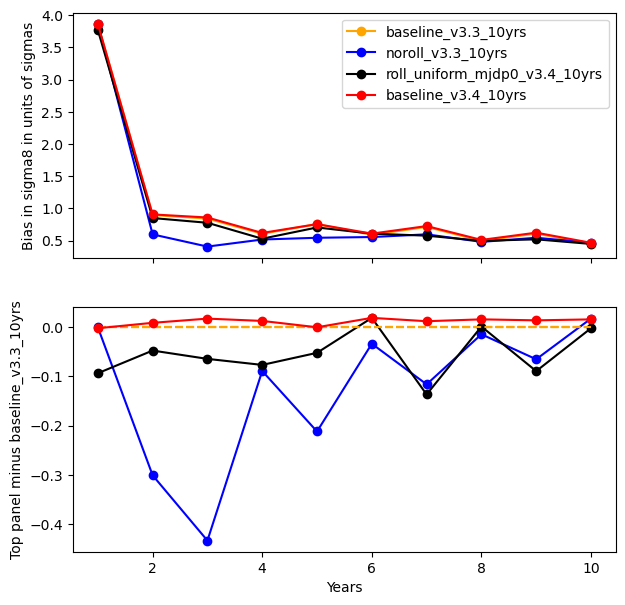

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

colors = ['orange', 'blue', 'black', 'red']
for i, run_name in enumerate(results_sigma8_squared_bias.keys()):
    axs[0].plot(years, results_sigma8_squared_bias[run_name], label=run_name, marker='o', color=colors[i])
axs[0].legend()

results_sigma8_squared_bias.keys()
axs[1].set_xlabel('Years')
axs[0].set_ylabel('Bias in sigma8 in units of sigmas')

run_name_ = list(results_sigma8_squared_bias.keys())[0]
for i, run_name in enumerate(results_sigma8_squared_bias.keys()):
    axs[1].plot(years, np.array(years)*0, ls='--', c='orange')
    if run_name != run_name_:
        axs[1].plot(years, results_sigma8_squared_bias[run_name]-results_sigma8_squared_bias[run_name_], label=run_name, marker='o', color=colors[i])
axs[1].set_ylabel('Top panel minus '+run_name_)

In [ ]:
%rm /global/homes/b/bleis89/ObsStrat/code/meanz_uniformity/*.npz

In [ ]:
stop

# Demo of AreaAtRisk metric

In [16]:
from rubin_sim.maf.metrics.cosmology_summary_metrics import UniformAreaFoMFractionMetric
from rubin_sim.maf.metrics.uniformity_metrics import NestedRIZExptimeExgalM5Metric
from rubin_sim.maf.metrics.weak_lensing_systematics_metric import RIZDetectionCoaddExposureTime, ExgalM5WithCuts
from rubin_sim.maf.metrics.exgal_m5 import ExgalM5

nside = 64

sim_list = [
   '/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
    '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
       '/pscratch/sd/b/beckermr/v3.4_sims_rubin/roll_uniform_mjdp0_v3.4_10yrs.db',
       '/pscratch/sd/b/beckermr/v3.4_sims_rubin/baseline_v3.4_10yrs.db'
           ]
name_list = [splitext(basename(sim))[0] for sim in sim_list]

years = range(1, 11) 
surveyAreas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = surveyAreas.return_maps()
slicer = maf.HealpixSubsetSlicer(
    nside=nside, 
    hpid=np.where(map_labels == "lowdust")[0],#hpid=np.arange(hp.nside2npix(nside)), 
    use_cache=False)

results_allruns= {}
for opsim_fname, run_name in zip(sim_list, name_list):

    results_allyears = np.zeros((len(years), ))
    # loop over years 
    for iy, year in enumerate(years):
        print('year', year)

        days = year*365.25
        constraint_str = 'note not like "DD%" and night <= XX and note not like "twilight_near_sun" '
        constraint_str = constraint_str.replace('XX','%d'%days)

        
        metric = NestedRIZExptimeExgalM5Metric(
            depth_cut=25.0 # what depth cuts to apply year after year?
        ) 
        summary_metrics = [UniformAreaFoMFractionMetric(
            year,
            nside=nside,
            verbose=False, 
            metric_name='FoMRatio'
        )]
        depth_map_bundles = [maf.MetricBundle(
            metric=metric,
            slicer=slicer,
            constraint=constraint_str,
            run_name=run_name,
            summary_metrics=summary_metrics
        )]
        bd = maf.metricBundles.make_bundles_dict_from_list(depth_map_bundles)
        bgroup = maf.MetricBundleGroup(bd, opsim_fname)
        bgroup.run_all()
        results_allyears[iy] = bd[list(bd.keys())[0]].summary_values['FoMRatio']
        
    results_allruns[run_name] = results_allyears

    

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
year 1


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


year 2


/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 3


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 4


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 5


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 6


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 7


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 8


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 9


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 10


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 1


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


year 2
year 3
year 4
year 5
year 6
year 7


/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 8


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


year 9
year 10
year 1
year 2


/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 3


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 4


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


year 5


/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 6


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 7


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


year 8


/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 9


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 10


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


year 1
year 2


/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 3


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 4


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 5


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 6


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 7


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 8


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 9


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


year 10


/pscratch/sd/b/bleis89/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/pscratch/sd/b/bleis89/my-desc-stack-weekly/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'FOM ratio')

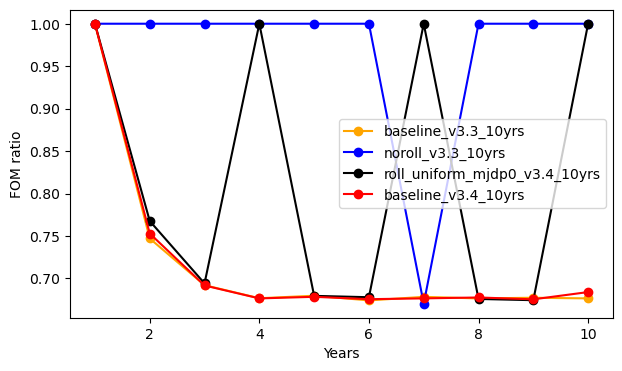

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(7, 4), sharex=True)
axs = [axs]
colors = ['orange', 'blue', 'black', 'red']
for i, run_name in enumerate(results_allruns.keys()):
    axs[0].plot(years, results_allruns[run_name], label=run_name, marker='o', color=colors[i])
axs[0].legend()

axs[0].set_xlabel('Years')
axs[0].set_ylabel('FOM ratio')

# Demo of meanz metric

In [ ]:
from rubin_sim.maf.metrics.cosmology_summary_metrics import MultibandMeanzBiasMetric
from rubin_sim.maf.metrics.uniformity_metrics import MultibandExgalM5
from rubin_sim.maf.metrics.weak_lensing_systematics_metric import RIZDetectionCoaddExposureTime, ExgalM5WithCuts
from rubin_sim.maf.metrics.exgal_m5 import ExgalM5

nside = 32

sim_list = [
    '/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
  #     '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
    #   '/pscratch/sd/b/beckermr/v3.4_sims_rubin/roll_uniform_mjdp0_v3.4_10yrs.db',
    #   '/pscratch/sd/b/beckermr/v3.4_sims_rubin/baseline_v3.4_10yrs.db'
           ]
name_list = [splitext(basename(sim))[0] for sim in sim_list]

years = range(1, 11) 
surveyAreas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = surveyAreas.return_maps()
slicer = maf.HealpixSubsetSlicer(
    nside=nside, 
    hpid=np.where(map_labels == "lowdust")[0],#hpid=np.arange(hp.nside2npix(nside)), 
    use_cache=False)

results_allruns= {}
for opsim_fname, run_name in zip(sim_list, name_list):

    results_allyears = np.zeros((len(years), ))
    # loop over years 
    for iy, year in enumerate(years):
        print('year', year)

        days = year*365.25
        constraint_str = 'note not like "DD%" and night <= XX and note not like "twilight_near_sun" '
        constraint_str = constraint_str.replace('XX','%d'%days)

        
        metric = MultibandExgalM5() 
        summary_metrics = [MultibandMeanzBiasMetric(year=year, 
                                                    metric_name='MultibandMeanzBias')]
        depth_map_bundles = [maf.MetricBundle(
            metric=metric,
            slicer=slicer,
            constraint=constraint_str,
            run_name=run_name,
            summary_metrics=summary_metrics
        )]
        bd = maf.metricBundles.make_bundles_dict_from_list(depth_map_bundles)
        bgroup = maf.MetricBundleGroup(bd, opsim_fname)
        bgroup.run_all()
        results_allyears[iy] = bd[list(bd.keys())[0]].summary_values['MultibandMeanzBias']
        
    results_allruns[run_name] = results_allyears

    